In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
from sklearn.model_selection import train_test_split
import sequitur
from sequitur import models

In [164]:
def load_data(filetype='sql'):
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    data.replace([1.1e+308], np.nan, inplace=True)
    data.fillna(np.nan, inplace=True)
    data.dropna(axis=1,how='all',inplace=True)
    #data['timestamp'] -= data['timestamp'].min()
    
    #data = (data - data.mean())/data.std()
    data = data.replace([np.nan], 0)
    return data

In [165]:
data = load_data('csv')
#data = data[25000:35000]

In [166]:
data

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,NOAA_WID,NOAA_TS,WIH000CDS,WIH000CDD,GPH000EDE,GPH000EDN,GPH000EDH,GPH000WDE,GPH000WDN,GPH000WDH,GPH000dDE,GPH000dDN,GPH000dDH,EXH077ED,EXH077WD,EXB077ED,EXB077WD,EXH077dD,EXB077dD,GPH000EDE_RMS,GPH000EDN_RMS,GPH000EDH_RMS,GPH000WDE_RMS,GPH000WDN_RMS,GPH000WDH_RMS,GPH000dDE_RMS,GPH000dDN_RMS,GPH000dDH_RMS,EXH077ED_RMS,...,RMS_VS3,RMS_TS1,RMS_VS4,RMS_VS5,RMS_TS2,RMS_LS1,RMS_LS2a,RMS_LS2c,RMS_LA2b,RMS_LS2d,FREQ_VS1,FREQ_VA1,FREQ_VS2a,FREQ_VS3,FREQ_TS1,FREQ_VS4,FREQ_VS5,FREQ_TS2,FREQ_LS1,FREQ_LS2a,FREQ_LS2c,FREQ_LA2b,FREQ_LS2d,DAMP_VS1,DAMP_VA1,DAMP_VS2a,DAMP_VS3,DAMP_TS1,DAMP_VS4,DAMP_VS5,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,63428486400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63428488200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,63428490000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63428491800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,63428493600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,63564134400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65404,63564136200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65405,63564138000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65406,63564139800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.333333

In [181]:
training_data = data.drop('timestamp', axis=1)
training_data.dropna(axis=0, how='all', inplace=True)
training_data.reset_index(drop=True)

,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,NOAA_WID,NOAA_TS,WIH000CDS,WIH000CDD,GPH000EDE,GPH000EDN,GPH000EDH,GPH000WDE,GPH000WDN,GPH000WDH,GPH000dDE,GPH000dDN,GPH000dDH,EXH077ED,EXH077WD,EXB077ED,EXB077WD,EXH077dD,EXB077dD,GPH000EDE_RMS,GPH000EDN_RMS,GPH000EDH_RMS,GPH000WDE_RMS,GPH000WDN_RMS,GPH000WDH_RMS,GPH000dDE_RMS,GPH000dDN_RMS,GPH000dDH_RMS,EXH077ED_RMS,EXH077WD_RMS,...,RMS_VS3,RMS_TS1,RMS_VS4,RMS_VS5,RMS_TS2,RMS_LS1,RMS_LS2a,RMS_LS2c,RMS_LA2b,RMS_LS2d,FREQ_VS1,FREQ_VA1,FREQ_VS2a,FREQ_VS3,FREQ_TS1,FREQ_VS4,FREQ_VS5,FREQ_TS2,FREQ_LS1,FREQ_LS2a,FREQ_LS2c,FREQ_LA2b,FREQ_LS2d,DAMP_VS1,DAMP_VA1,DAMP_VS2a,DAMP_VS3,DAMP_TS1,DAMP_VS4,DAMP_VS5,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.333333,247.5,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [171]:
training_data = (training_data - training_data.mean())/training_data.std()

In [176]:
training_data

,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,NOAA_WIS,NOAA_WID,NOAA_TS,WIH000CDS,WIH000CDD,GPH000EDE,GPH000EDN,GPH000EDH,GPH000WDE,GPH000WDN,GPH000WDH,GPH000dDE,GPH000dDN,GPH000dDH,EXH077ED,EXH077WD,EXB077ED,EXB077WD,EXH077dD,EXB077dD,GPH000EDE_RMS,GPH000EDN_RMS,GPH000EDH_RMS,GPH000WDE_RMS,GPH000WDN_RMS,GPH000WDH_RMS,GPH000dDE_RMS,GPH000dDN_RMS,GPH000dDH_RMS,EXH077ED_RMS,EXH077WD_RMS,...,RMS_VS3,RMS_TS1,RMS_VS4,RMS_VS5,RMS_TS2,RMS_LS1,RMS_LS2a,RMS_LS2c,RMS_LA2b,RMS_LS2d,FREQ_VS1,FREQ_VA1,FREQ_VS2a,FREQ_VS3,FREQ_TS1,FREQ_VS4,FREQ_VS5,FREQ_TS2,FREQ_LS1,FREQ_LS2a,FREQ_LS2c,FREQ_LA2b,FREQ_LS2d,DAMP_VS1,DAMP_VA1,DAMP_VS2a,DAMP_VS3,DAMP_TS1,DAMP_VS4,DAMP_VS5,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
0,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,-1.544512,-1.470968,-0.659758,-0.679025,-0.111879,-0.192478,-0.207648,-0.155544,-0.18927,-0.189509,0.118427,-0.044774,-0.166095,-0.41217,-0.428662,-0.230427,-0.277885,0.150817,-0.165603,-0.179578,-0.187055,-0.049637,-0.180298,-0.20072,-0.043625,-0.168177,-0.145437,-0.183141,-0.098524,-0.031182,...,-0.684352,-0.498835,-0.671016,-0.649627,-0.528921,-0.452925,-0.796585,-0.763262,-0.681489,-0.783018,-1.232108,-1.220678,-1.229703,-1.233552,-1.233776,-1.233986,-1.233974,-1.233802,-1.143989,-1.129812,-1.151833,-1.151334,-1.151641,-1.04828,-0.888207,-1.010929,-0.982723,-1.103623,-0.967668,-1.059285,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
1,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,-1.544512,-1.470968,-0.659758,-0.679025,-0.111879,-0.192478,-0.207648,-0.155544,-0.18927,-0.189509,0.118427,-0.044774,-0.166095,-0.41217,-0.428662,-0.230427,-0.277885,0.150817,-0.165603,-0.179578,-0.187055,-0.049637,-0.180298,-0.20072,-0.043625,-0.168177,-0.145437,-0.183141,-0.098524,-0.031182,...,-0.684352,-0.498835,-0.671016,-0.649627,-0.528921,-0.452925,-0.796585,-0.763262,-0.681489,-0.783018,-1.232108,-1.220678,-1.229703,-1.233552,-1.233776,-1.233986,-1.233974,-1.233802,-1.143989,-1.129812,-1.151833,-1.151334,-1.151641,-1.04828,-0.888207,-1.010929,-0.982723,-1.103623,-0.967668,-1.059285,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
2,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,-1.544512,-1.470968,-0.659758,-0.679025,-0.111879,-0.192478,-0.207648,-0.155544,-0.18927,-0.189509,0.118427,-0.044774,-0.166095,-0.41217,-0.428662,-0.230427,-0.277885,0.150817,-0.165603,-0.179578,-0.187055,-0.049637,-0.180298,-0.20072,-0.043625,-0.168177,-0.145437,-0.183141,-0.098524,-0.031182,...,-0.684352,-0.498835,-0.671016,-0.649627,-0.528921,-0.452925,-0.796585,-0.763262,-0.681489,-0.783018,-1.232108,-1.220678,-1.229703,-1.233552,-1.233776,-1.233986,-1.233974,-1.233802,-1.143989,-1.129812,-1.151833,-1.151334,-1.151641,-1.04828,-0.888207,-1.010929,-0.982723,-1.103623,-0.967668,-1.059285,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-0.871544,-0.475822,-0.532053,-0.536959,-0.566614
3,-0.832531,-0.832108,-0.874945,-0.906868,-0.928825,-0.96353,-0.885055,-0.706863,-0.689689,-1.392911,-1.544512,-1.470968,-0.659758,-0.679025,-0.111879,-0.192478,-0.207648,-0.155544,-0.18927,-0.189509,0.118427,-0.044774,-0.166095,-0.41217,-0.428662,-0.230427,-0.277885,0.150817,-0.165603,-0.179578,-0.187055,-0.049637,-0.180298,-0.20072,-0.043625,-0.168177,-0.145437,-0.183141,-0.098524,-0.031182,...,-0.684352,-0.498835,-0.671016,-0.649627,-0.528921,-0.452925,-0.796585,-0.763262,-0.681489,-0.783018,-1.232108,-1.220678,-1.229703,-1.233552,-1.233776,-1.233986,-1.233974,-1.233802,-1.143989,-1.129812,-1.151833,-1.151334,-1.151641,-1.04828,-0.888207,-1.010929,-0.982723,-1.103623,-0.967668,-1.059285,-1.112478,-0.946007,-0.948214,-1.009509,-0.991861,-

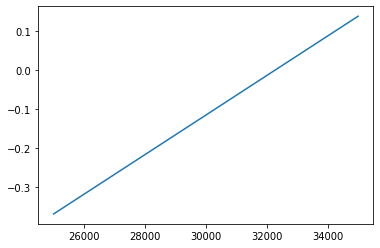

In [57]:
plt.plot(data['timestamp'])

In [88]:
#plt.plot(training_data)

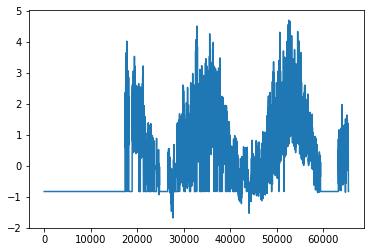

In [177]:
plt.plot(training_data['TSH000ED'])#[25000:35000])

In [173]:
torch.from_numpy(data.values)

tensor([[6.3428e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3428e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3428e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.3564e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3564e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3564e+13, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64)

In [12]:
num_epochs=10
batch_size=100
learning_rate=1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
tensor_data = torch.tensor(data['RMS_VE'].values.astype(np.float32))
load = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [14]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [19]:
train_set = [torch.randn(10,5,5) for _ in range(100)]

In [178]:
dataset, seq_len, n_features = create_dataset(training_data)

In [179]:
encoder, decoder, encodings, losses = sequitur.quick_train(models.LINEAR_AE, dataset, 10, True, 0.001, 20)

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Loss: 5.924330387839265
Epoch: 2, Loss: 4.039291155607129
Epoch: 3, Loss: 3.3455632566316127
Epoch: 4, Loss: 2.8916152400838695
Epoch: 5, Loss: 2.554291298871708
Epoch: 6, Loss: 2.2777934919448506
Epoch: 7, Loss: 2.06064577586732
Epoch: 8, Loss: 1.8864660609071462
Epoch: 9, Loss: 1.7479067319663624
Epoch: 10, Loss: 1.6382036999620633
Epoch: 11, Loss: 1.5446750231217632
Epoch: 12, Loss: 1.4642489709180158
Epoch: 13, Loss: 1.3955170776206223
Epoch: 14, Loss: 1.3415732983820043
Epoch: 15, Loss: 1.2907982224475976
Epoch: 16, Loss: 1.2375251298304828
Epoch: 17, Loss: 1.1888591513902798
Epoch: 18, Loss: 1.142636761914823
Epoch: 19, Loss: 1.0988572754184136
Epoch: 20, Loss: 1.0767173896332192


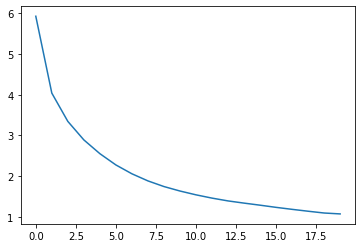

In [180]:
plt.plot(losses)

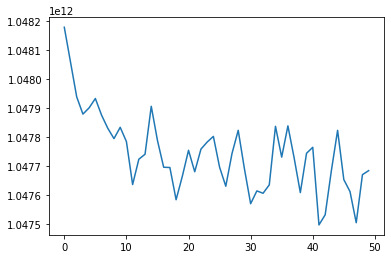

In [96]:
plt.plot(losses)

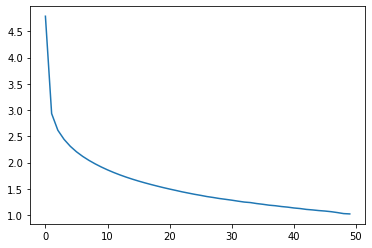

In [73]:
plt.plot(losses)

In [31]:
len(dataset[0])

134

In [48]:
for idx, item in enumerate(load):
    print(idx, item.view(-1,len(item)))
    break

0 tensor([[1.2511, 1.1271, 1.8600, 1.2282, 1.5207, 1.2647, 1.1400, 1.2847, 1.0171,
         1.4057, 1.3552, 1.1208, 1.1660, 1.1384, 1.1471, 0.9407, 0.9383, 1.0409,
         1.4231, 0.9323, 1.1629, 1.0826, 1.0511, 0.9068, 0.9876, 1.3208, 1.0522,
         0.8705, 0.6813, 0.8923, 0.9470, 1.1603, 0.9544, 0.9846, 0.9245, 1.2407,
         1.1755, 1.1780, 1.0732, 1.0021, 0.8782, 0.8179, 0.3731, 0.5246, 0.3795,
         0.4737, 0.8632, 0.7981, 0.6389, 0.7082, 0.9093, 0.6802, 1.0034, 0.9509,
         1.0199, 0.9199, 0.8684, 0.9347, 1.0726, 0.9452, 1.0120, 1.0657, 1.0017,
         0.9384, 1.0099, 1.0713, 1.1380, 0.9822, 0.8211, 0.9539, 0.8267, 0.9783,
         0.8633, 0.7762, 0.5450, 0.8740, 0.4254, 0.3957, 0.4366, 0.5874, 0.3538,
         0.2721, 0.4339, 0.2089, 0.4943, 0.8820, 0.3481, 0.4344, 0.3692, 0.6360,
         0.6712, 0.7660, 1.1150, 1.3249, 1.7295, 2.1041, 2.0530, 2.1517, 2.7353,
         2.4007]])


In [10]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 100)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [154]:
model = AutoEncoder()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []

for epoch in range(num_epochs):
    #item = item.to(device)
    for idx, item in enumerate(load):
        # forward
        item = item.view(len(item), -1)
        output = model(item)
        loss = loss_func(output, item)
        
        # backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_list.append(loss)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 128x62)